In [2]:
import pandas as pd
import numpy as np

import nltk
from nltk.corpus import stopwords
from nltk import word_tokenize
from nltk.stem import PorterStemmer
from nltk.corpus import wordnet

import string

import re

from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import train_test_split
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import classification_report

from sklearn import metrics

import matplotlib.pyplot as plt
import seaborn as sns



In [3]:
# import data
df = pd.read_csv('abusive_language_data.csv')
print(df.shape)
df.head()

(40623, 11)


,Unnamed: 0,id,text,label,type,model_wrong,db.model_preds,status,round,split,annotator
0,1,10000,It should be legal for a husband to rape his wife,hate,notgiven,True,0.97457,dynabench entry,1,train,gnzuctwed3
1,2,10001,dalits are lowlife scum,hate,notgiven,False,0.08233,dynabench entry,1,test,cagnluiznm
2,3,10002,dalits are lowlives,hate,notgiven,True,0.92319,dynabench entry,1,train,cagnluiznm
3,4,10003,It was a better world when women dare not ques...,hate,notgiven,True,0.99006,dynabench entry,1,test,gnzuctwed3
4,5,10004,I don't work this hard so that those immigrant...,hate,notgiven,True,0.98836,dynabench entry,1,train,cagnluiznm


In [4]:
df.isnull().sum()

Unnamed: 0            0
id                    0
text                  0
label                 0
type                  0
model_wrong       14526
db.model_preds    14526
status                0
round                 0
split                 0
annotator             0
dtype: int64

In [5]:
df.duplicated().sum()

0

In [6]:
df = df.dropna()
df.shape

(26097, 11)

In [7]:
df['label'].value_counts()

hate       15253
nothate    10844
Name: label, dtype: int64

In [8]:
# redefine the df as only inclusing those texts where the annotator and the model agreed (i.e., where model_wrong == False)
df = df[df['model_wrong'] == False]
df.head()

,Unnamed: 0,id,text,label,type,model_wrong,db.model_preds,status,round,split,annotator
1,2,10001,dalits are lowlife scum,hate,notgiven,False,0.08233,dynabench entry,1,test,cagnluiznm
9,10,10009,I don't work this hard so that all those pakis...,hate,notgiven,False,0.09288,dynabench entry,1,train,cagnluiznm
10,11,10010,I don't work this hard so that all those musli...,hate,notgiven,False,0.46144,dynabench entry,1,train,cagnluiznm
21,22,10022,Why is it that Africans smell weird? Do they n...,hate,notgiven,False,0.37971,dynabench entry,1,train,cagnluiznm
26,27,10027,I dont hate hindus,nothate,none,False,0.97793,dynabench entry,1,train,vde7gn0nrl


In [9]:
df['model_wrong'].value_counts()

False    10661
Name: model_wrong, dtype: int64

In [10]:
df.head()

,Unnamed: 0,id,text,label,type,model_wrong,db.model_preds,status,round,split,annotator
1,2,10001,dalits are lowlife scum,hate,notgiven,False,0.08233,dynabench entry,1,test,cagnluiznm
9,10,10009,I don't work this hard so that all those pakis...,hate,notgiven,False,0.09288,dynabench entry,1,train,cagnluiznm
10,11,10010,I don't work this hard so that all those musli...,hate,notgiven,False,0.46144,dynabench entry,1,train,cagnluiznm
21,22,10022,Why is it that Africans smell weird? Do they n...,hate,notgiven,False,0.37971,dynabench entry,1,train,cagnluiznm
26,27,10027,I dont hate hindus,nothate,none,False,0.97793,dynabench entry,1,train,vde7gn0nrl


In [11]:
cond = df['label'] == 'hate'

In [12]:
# print sample of first 10 texts labeled "correctly" as hate:

for t in df[cond]['text'][:20]:
    print(t)
    print('\n')

dalits are lowlife scum


I don't work this hard so that all those pakis can take the benefits


I don't work this hard so that all those muslims can take the benefits


Why is it that Africans smell weird? Do they not wash?


Arabs are dumb


Be quiet, you silly little girl


Gay men are such crybabies


her personality is filthy lol, typical woman


Refugees are disgusting


Refugees are dirty


down syndrome is retarded


Foreigners suck


discrimination against homos is not wrong and disgusting, its good


Britain is full of dogs


black people need to die


gay people need to die


gays need to die


refugees need to die


girls need to die


lesbians need to die




In [13]:
cond_NA = df['label'] == 'nothate'

In [14]:
# print sample of first 10 texts labeled "correctly" as nothate:

for t in df[cond_NA]['text'][:20]:
    print(t)
    print('\n')

I dont hate hindus


I dont hate Muslims


The world full of women is unfair


short people are somehow not smart


short people are smart to some extent


short people are damn smart


short men are fucking weird


tall men are intelligent


kids are dumb


pear is not tasty


blonde people are not smart


Terrorists must be Muslims


Terrorists are always Muslim but never white


Indian people are not smart


Indian people smell like spices


gay people need medical treatment


her house is filthy lol


any normal person with a brain would agree that whatever comes out of misogynists mouth is complete bullshit


discrimination against women is so wrong and disgusting


biden needs to shoot himself




In [15]:
df['label'].value_counts()

hate       5441
nothate    5220
Name: label, dtype: int64

In [16]:
# lowercase all words:
def make_lower(a_string):
    return a_string.lower()

# test it
my_sent = 'ALL CAPS AND NOTHING ELSE HERE'
make_lower(my_sent)

'all caps and nothing else here'

In [17]:
# look at "new" df
df.head(10)

,Unnamed: 0,id,text,label,type,model_wrong,db.model_preds,status,round,split,annotator
1,2,10001,dalits are lowlife scum,hate,notgiven,False,0.08233,dynabench entry,1,test,cagnluiznm
9,10,10009,I don't work this hard so that all those pakis...,hate,notgiven,False,0.09288,dynabench entry,1,train,cagnluiznm
10,11,10010,I don't work this hard so that all those musli...,hate,notgiven,False,0.46144,dynabench entry,1,train,cagnluiznm
21,22,10022,Why is it that Africans smell weird? Do they n...,hate,notgiven,False,0.37971,dynabench entry,1,train,cagnluiznm
26,27,10027,I dont hate hindus,nothate,none,False,0.97793,dynabench entry,1,train,vde7gn0nrl
27,28,10028,I dont hate Muslims,nothate,none,False,0.98672,dynabench entry,1,train,vde7gn0nrl
30,31,10031,The world full of women is unfair,nothate,none,False,0.98859,dynabench entry,1,train,vde7gn0nrl
32,33,10033,short people are somehow not smart,nothate,none,False,0.99206,dynabench entry,1,train,vde7gn0nrl
33,34,10034,short people are smart to some extent,nothate,none,False,0.99844,dynabench entry,1,train,vde7gn0nrl
34,35,10035,short people are damn smart,nothate,none,False,0.99303,dynabench entry,1,train,vde7gn0nrl


In [18]:
df['new_label'] = np.where(cond, 'abusive', 'not abusive')

<AxesSubplot:>

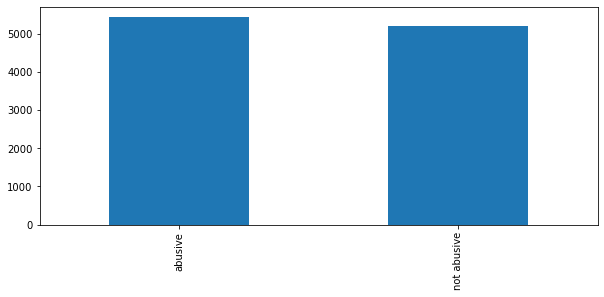

In [19]:
plt.figure(figsize=(10,4))
df.new_label.value_counts().plot(kind='bar')

In [20]:
df['new_label'].value_counts()

abusive        5441
not abusive    5220
Name: new_label, dtype: int64

In [21]:
# lower case only, leave punc in, don't stem words

df['text_clean'] = df['text'].apply(make_lower)

In [22]:
df.head()

,Unnamed: 0,id,text,label,type,model_wrong,db.model_preds,status,round,split,annotator,new_label,text_clean
1,2,10001,dalits are lowlife scum,hate,notgiven,False,0.08233,dynabench entry,1,test,cagnluiznm,abusive,dalits are lowlife scum
9,10,10009,I don't work this hard so that all those pakis...,hate,notgiven,False,0.09288,dynabench entry,1,train,cagnluiznm,abusive,i don't work this hard so that all those pakis...
10,11,10010,I don't work this hard so that all those musli...,hate,notgiven,False,0.46144,dynabench entry,1,train,cagnluiznm,abusive,i don't work this hard so that all those musli...
21,22,10022,Why is it that Africans smell weird? Do they n...,hate,notgiven,False,0.37971,dynabench entry,1,train,cagnluiznm,abusive,why is it that africans smell weird? do they n...
26,27,10027,I dont hate hindus,nothate,none,False,0.97793,dynabench entry,1,train,vde7gn0nrl,not abusive,i dont hate hindus


In [23]:
df.shape

(10661, 13)

In [24]:
# define variables:

X = df['text_clean'].values

y = df['new_label'].values

In [25]:
# now try using n_grams

vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(X)

In [26]:
from sklearn import svm

X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.25, random_state=42)

model = svm.SVC(probability=True)

model.fit(X_train, y_train)

SVC(probability=True)

In [27]:
accuracy = model.score(X_test, y_test)
print('Accuracy', accuracy)

Accuracy 0.8660915228807202


In [28]:
y_pred = model.predict(X_test)

In [29]:
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

     abusive       0.87      0.86      0.86      1328
 not abusive       0.86      0.87      0.87      1338

    accuracy                           0.87      2666
   macro avg       0.87      0.87      0.87      2666
weighted avg       0.87      0.87      0.87      2666



In [30]:
X = vectorizer.transform(['I love apples.'])
            
# Make a prediction 
predictions = model.predict(X)

# Get the first and only value of the prediction.
prediction = predictions[0]

# Get the predicted probabs
predicted_probas = model.predict_proba(X)

# Get the value of the first, and only, predicted proba.
predicted_proba = predicted_probas[0]

# The first element in the predicted probabs is % abusive 
percent_abusive = predicted_proba[0]

# The second elemnt in predicted probas is % not abusive
percent_notAbusive = predicted_proba[1]


In [31]:
print(predicted_proba)
print(prediction)

[0.82465251 0.17534749]
abusive


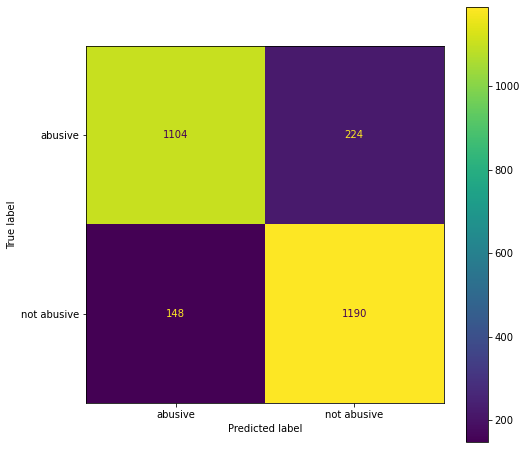

In [30]:
fig, ax = plt.subplots(figsize=(8,8))
metrics.plot_confusion_matrix(estimator=model, 
                              X=X_test, 
                              y_true=y_test, 
                              ax=ax)

In [33]:
# pipeline for building and evaluating models

def build_and_eval_model(model, X, Y, random_state=42):
    print('Running report for model', model)
    
    # test, train, split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.25, random_state=random_state)
    
    # fit the model
    model.fit(X_train, y_train)
    
    # get and print accuracy
    accuracy = model.score(X_test, y_test)
    print('\n\nAccuracy %f' % accuracy)
    
    # makde new predictions
    y_pred = model.predict(X_test)
    
    # print classification report
    print(metrics.classification_report(y_test, y_pred))
    
    # plot confusion matrix
    fig, ax = plt.subplots(figsize=(13,13))
    
    metrics.plot_confusion_matrix(estimator=model,
                                 X=X_test,
                                 y_true=y_test,
                                 ax=ax)
    
    return model

In [34]:
# Multinomial NB
mnb = MultinomialNB()
build_and_eval_model(mnb, X, y)

Running report for model MultinomialNB()


ValueError: Found input variables with inconsistent numbers of samples: [1, 10661]

Running report for model LogisticRegression()


Accuracy 0.842461
              precision    recall  f1-score   support

     abusive       0.84      0.85      0.84      1328
 not abusive       0.85      0.84      0.84      1338

    accuracy                           0.84      2666
   macro avg       0.84      0.84      0.84      2666
weighted avg       0.84      0.84      0.84      2666



LogisticRegression()

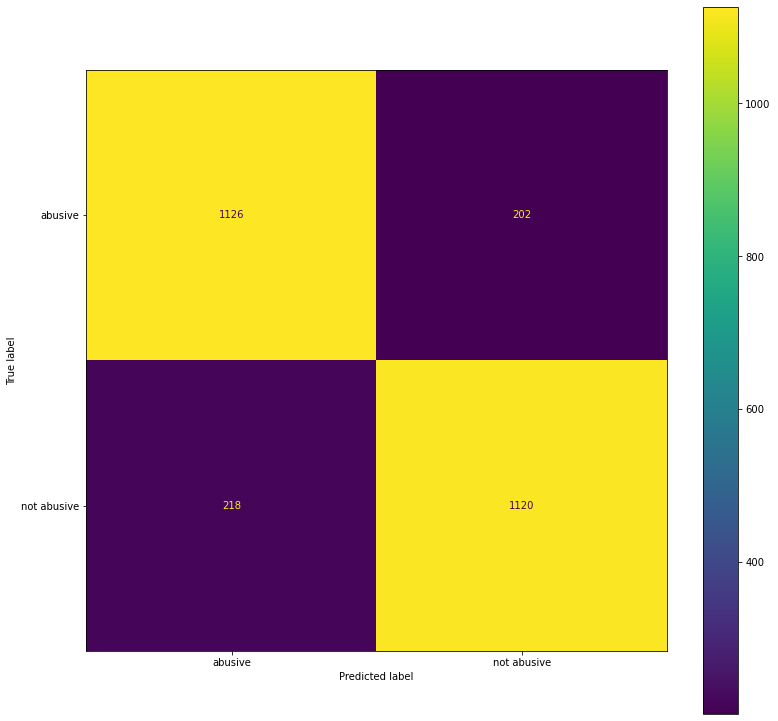

In [33]:
# Logistic Regression
lr = LogisticRegression()
build_and_eval_model(lr, X, y)

Running report for model RandomForestClassifier()


Accuracy 0.825581
              precision    recall  f1-score   support

     abusive       0.83      0.81      0.82      1328
 not abusive       0.82      0.84      0.83      1338

    accuracy                           0.83      2666
   macro avg       0.83      0.83      0.83      2666
weighted avg       0.83      0.83      0.83      2666



RandomForestClassifier()

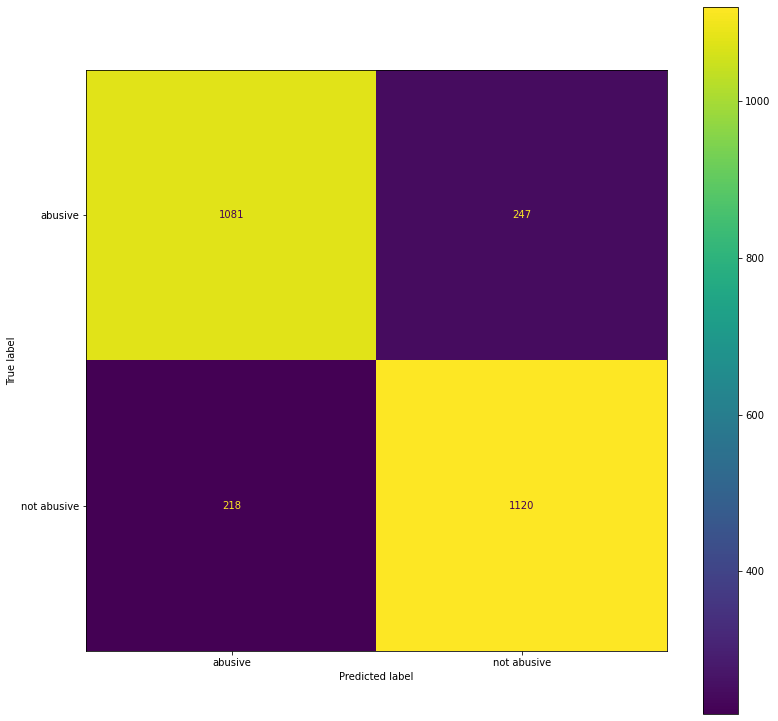

In [34]:
# Random Forest
rf = RandomForestClassifier()
build_and_eval_model(rf, X, y)

In [35]:
data = {'Model': ['Multinomial Naive Bayes','Logistic Regression','Random Forest', 'Support Vector Machine'],
        'Accuracy': [ 0.842, 0.842, 0.826, 0.860]
        }

df_1 = pd.DataFrame(data, columns = ['Model', 'Accuracy'])
df_1

,Model,Accuracy
0,Multinomial Naive Bayes,0.842
1,Logistic Regression,0.842
2,Random Forest,0.826
3,Support Vector Machine,0.860
